In [66]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


In [67]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [68]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [69]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [70]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor\\SiPM.py'>

In [104]:
D0 = SiPM.SiPM(Path='C:/Data/20211119/', 
                    Selection='*HighRes*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
print(D0.Files)
for File in D0.Files[:1]:
    D0.ImportDataFromHDF5(File, D0.Ch)

['C:/Data/20211119\\GXe_SiPM_Burst_HighRes_0.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_1.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_10.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_2.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_3.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_4.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_5.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_6.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_7.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_8.h5', 'C:/Data/20211119\\GXe_SiPM_Burst_HighRes_9.h5']


In [105]:
print('nr of samples: ',len(D0.Ch[1].Time))
print('total time in us: ', D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])
print('time between samples in us: ', (D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time))
print('sampling rate in MHz: ',1/((D0.Ch[1].Time[-1]- D0.Ch[1].Time[0])/len(D0.Ch[1].Time)))

nr of samples:  99208
total time in us:  100000.65599999999
time between samples in us:  1.00798983952907
sampling rate in MHz:  0.9920734919978926


[ 4.57344123e-01  3.31500219e+01  1.59807870e+00  5.18545581e+01
 -1.22574533e+04]


(-13000.0, -11000.0)

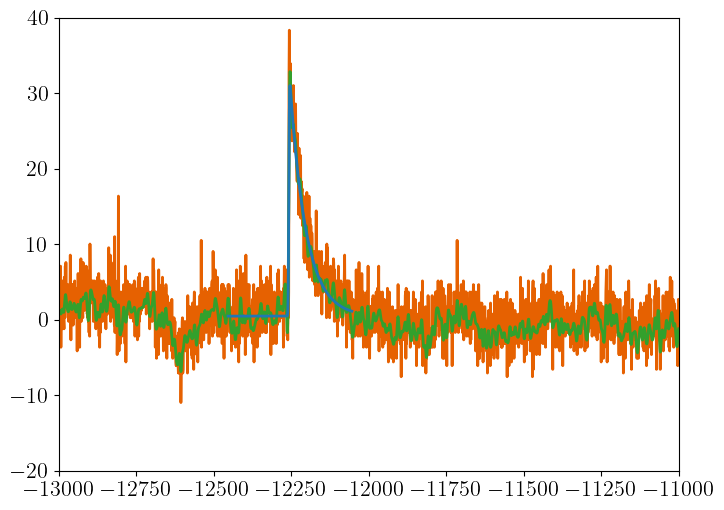

In [106]:
time = D0.Ch[0].Time

data = D0.get_filtered_waveform(D0.Ch[0].Time, D0.Ch[0].Amp[0], lowfreq=100, highfreq=100000, type='band', order=3)
peaks,pdict = find_peaks(data, height=20, width=20, distance=50)
for ii,p in enumerate(peaks): 
    pp = time[p]
    ph = pdict['peak_heights'][ii]
    fit = np.where((time>time[p]-200) & (time<time[p]+200))
    popt, pcov = curve_fit(D0.func, time[fit], data[fit], p0=[0, ph, 1, 40, pp], maxfev=10000)
    print(popt)
    plt.plot(time[fit], D0.func(time[fit], *popt) , zorder=10 )


plt.plot(D0.Ch[0].Time, D0.Ch[0].Amp[0])
plt.plot(D0.Ch[0].Time, data)
step = 1
xmin = -50000+1000*step
xmax = xmin+1000
plt.xlim(-13000,-11000)
# plt.ylim(-60,60)

In [107]:
start = D0.Ch[1].Time[0]
length = D0.Ch[1].Time[-1] - D0.Ch[1].Time[0]
window = 1000
count = int(length/window)
print(start, length,window, count)

-50000.327999999994 100000.65599999999 1000 100


In [108]:
print(len(D0.Ch[0].Amp))

100


In [109]:
maxval = []
for i,Amp in enumerate(D0.Ch[0].Amp):
    print(i)
    # NewAmp = Amp-np.mean(Amp)
    for j in range(count):
        offset = window*j
        cut = np.where((D0.Ch[0].Time > start+offset) & (D0.Ch[0].Time < start+offset+window))[0]
        
        y = D0.get_filtered_waveform(D0.Ch[0].Time, Amp, lowfreq=100, highfreq=100000, type='band', order=3)[cut]
        maxval.append(np.max(y))
        D0.fit_peaks(D0.Ch[0].Time[cut], y)
D0.fit_parameters = np.array(D0.fit_parameters)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [101]:
print(np.shape(D0.fit_parameters))
print(len(D0.fit_parameters[:,1]))

(20, 5)
20


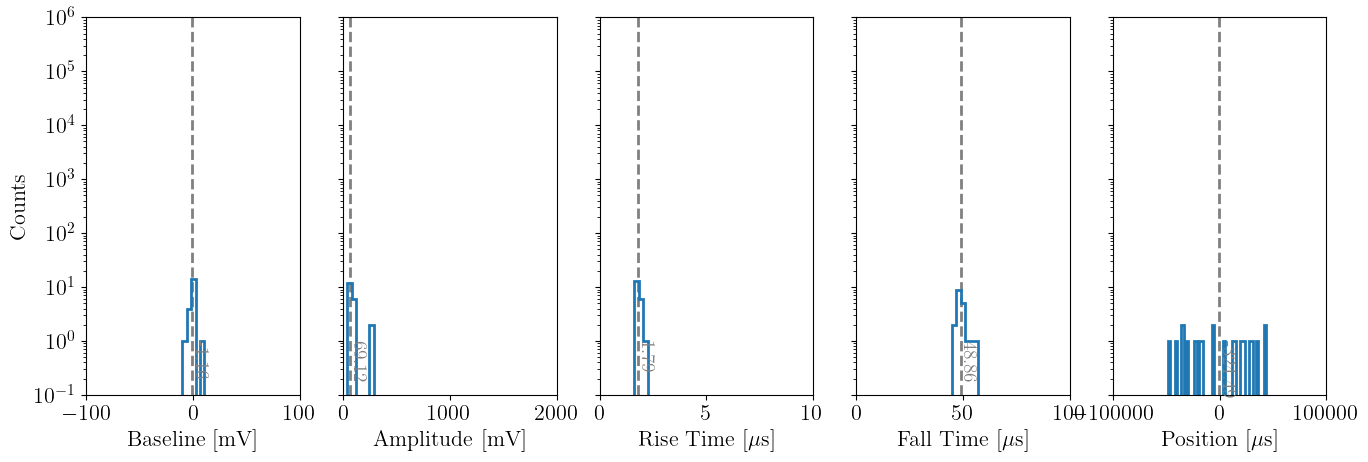

In [96]:
labels = ['Baseline [mV]', 'Amplitude [mV]', 'Rise Time [$\mu$s]', 'Fall Time [$\mu$s]', 'Position [$\mu$s]']
mins = [-100,0,0,0,start]
maxs = [100,2000,10,100,start+2*np.abs(start)]

fig, ax = plt.subplots(figsize=(16,5), ncols=5, nrows=1,sharey=True,facecolor='white')
ax[0].set_ylabel('Counts')
for i in range(np.shape(D0.fit_parameters)[1]):
    
    ax[i].hist(D0.fit_parameters[:,i], bins=np.linspace(mins[i],maxs[i],50), 
               color=colors[0], histtype='step', align='mid', label='All Events', lw=2)
    ax[i].vlines(np.median(D0.fit_parameters[:,i]), ymin=0.1, ymax=1e6, ls='--', color='grey')
    ax[i].text(s="{:.2f}".format(np.median(D0.fit_parameters[:,i])), 
               x=np.median(D0.fit_parameters[:,i])*1,y=1, color='grey', size=14, rotation=270, va='top')
    
    
    ax[i].set_xlabel(labels[i])
    ax[i].set_yscale('log')
    # ax[i].set_xlim(mins[i], maxs[i])
    # ax[i].set_ylim(1e-1, 1e2)
#     ax[i].legend(loc='upper right')
plt.savefig('fit_parameters.pdf')
plt.show()

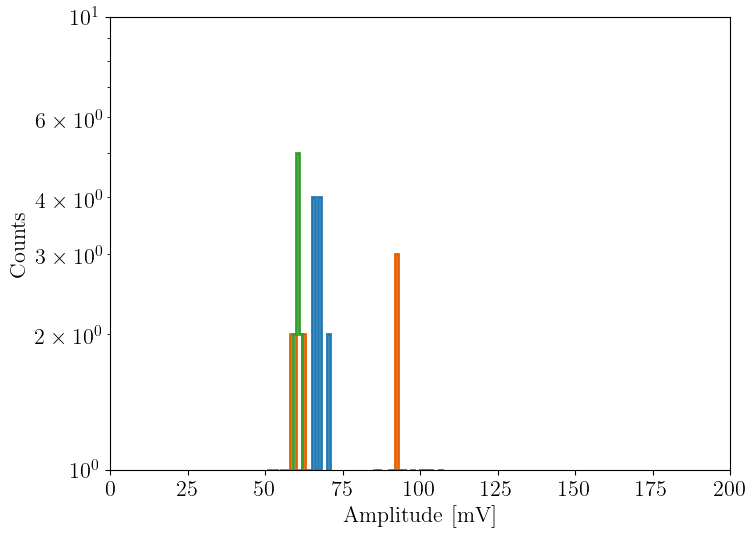

In [110]:
plt.figure()
plt.xlabel('Amplitude [mV]')
plt.ylabel('Counts')
plt.yscale('log')


binmax = 200
binsize = 1

plt.hist(D0.fit_parameters[:,1], 
         bins=np.arange(0,binmax,binsize), histtype='step', lw=2)

plt.hist(D0.max, bins=np.arange(0,binmax,binsize), histtype='step', lw=2)

plt.hist(D0.max-D0.fit_parameters[:,0][D0.fit_parameters[:,0]!=0], 
         bins=np.arange(0,binmax,binsize), histtype='step', lw=2)
plt.show()